In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# XGBoost, NAICS Embeddings from Unsupervised GNN (including target as feature)
Retry an XGBoost model but use the NAICS embeddings generated by an unsupervised GNN (base features plus target)

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance, partial_dependence
from scikitplot.metrics import plot_lift_curve

In [5]:
from sba_gnn.sba_gnn import sg_plot 

## Import Processed Datasets

In [6]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [7]:
embed_df = pd.read_parquet(Path(setup.temp_path).joinpath('43_DATA_embeddings.parquet')) 

In [8]:
sba_loans = sba_loans.merge(embed_df.rename(columns={'NAICS_orig':'NAICS'}),
                            on='NAICS', how='left')

In [9]:
train_df = sba_loans[sba_loans['dset'] == 'train'].copy()
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

In [10]:
train_df.shape

(425594, 66)

In [11]:
train_df.drop_duplicates('LoanNr_ChkDgt').shape

(425594, 66)

#### Set the predictor features.  Inlcude the mean-encoded NAICS

In [12]:
predictor_features = setup.predictor_features + [c for c in embed_df.columns if c.startswith('emb')]
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'emb_000', 'emb_001', 'emb_002', 'emb_003', 'emb_004', 'emb_005', 'emb_006', 'emb_007', 'emb_008', 'emb_009', 'emb_010', 'emb_011', 'emb_012', 'emb_013', 'emb_014', 'emb_015']


In [13]:
train_df[predictor_features].describe()

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,emb_000,emb_001,emb_002,...,emb_006,emb_007,emb_008,emb_009,emb_010,emb_011,emb_012,emb_013,emb_014,emb_015
count,425594.000000,425594.000000,422477.000000,4.255940e+05,425050.000000,342255.000000,425594.000000,425594.000000,425594.000000,425594.000000,...,425594.000000,425594.000000,425594.000000,425594.000000,425594.000000,425594.000000,425594.000000,425594.000000,425594.000000,425594.000000
mean,9.758920,2.172277,0.097807,1.949280e+05,0.279906,0.814930,0.050858,0.251147,-0.184985,0.265880,...,0.056378,-0.201581,-0.074094,0.010867,0.015997,0.298887,0.290597,0.246907,0.160350,-0.309580
std,63.011166,15.140139,0.297053,2.994808e+05,0.448953,0.388355,0.219709,0.018333,0.013503,0.019408,...,0.004115,0.014714,0.352162,0.072526,0.065291,0.033045,0.353717,0.278843,0.056500,0.038782
min,0.000000,0.000000,0.000000,4.000000e+03,0.000000,0.000000,0.000000,0.194807,-0.225413,0.206235,...,0.043731,-0.245635,-0.611758,-0.315392,-0.303221,0.042634,-0.531307,-0.481289,-0.206889,-0.488191
25%,2.000000,0.000000,0.000000,3.600000e+04,0.000000,1.000000,0.000000,0.238131,-0.194301,0.252100,...,0.053456,-0.211732,-0.446349,-0.035302,-0.022388,0.282025,0.077421,0.007943,0.136762,-0.334941
50%,4.000000,0.000000,0.000000,9.000000e+04,0.000000,1.000000,0.000000,0.249385,-0.183688,0.264014,...,0.055982,-0.200166,-0.106916,0.005690,0.020839,0.304337,0.485781,0.303954,0.168544,-0.314872
75%,9.000000,2.000000,0.000000,2.157000e+05,1.000000,1.000000,0.000000,0.263794,-0.175398,0.279269,...,0.059217,-0.191134,0.252707,0.061903,0.061923,0.321608,0.527324,0.484203,0.198214,-0.287207
max,9992.000000,5621.000000,1.000000,1.144632e+07,1.000000,1.000000,1.000000,0.306033,-0.143487,0.323986,...,0.068699,-0.156360,0.519995,0.316468,0.269252,0.396100,0.635100,0.607392,0.341071,0.016715


In [14]:
tcorr = train_df[predictor_features + ['target']].corr()
tcorr.to_csv(Path(setup.temp_path).joinpath('52_REPORT_correlations.csv'))
tcorr[tcorr.index == 'target']

,NoEmp,CreateJob,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,emb_000,emb_001,emb_002,...,emb_007,emb_008,emb_009,emb_010,emb_011,emb_012,emb_013,emb_014,emb_015,target
target,-0.027838,-0.00954,-0.076836,-0.122857,0.014277,0.054391,-0.011047,0.001197,-0.001197,0.001197,...,-0.001197,0.099975,-0.034369,-0.041811,0.066043,0.153904,-0.087075,0.054588,-0.103159,1.0


In [15]:
with open(Path(setup.temp_path).joinpath('52_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

## Model Fit

In [16]:
best_params_df = pd.read_csv(Path(setup.temp_path).joinpath('03_REPORT_fit_parameter_selected.csv'))
best_params = best_params_df.to_dict(orient='records')[0]
best_params

{'subsample': 0.8,
 'scale_pos_weight': 1.0,
 'reg_lambda': 0.01,
 'reg_alpha': 0.001,
 'min_child_weight': 50,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 2}

##### Fit using pre-determined parameters

In [17]:
xgb_params = dict(best_params, 
                   **{'objective':"binary:logistic", 'n_estimators':setup.xgb_n_estimators})

In [18]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators = setup.xgb_n_estimators)

In [19]:
xgb_model = xgb_model.set_params(**xgb_params)

In [20]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.49953	validation_1-logloss:0.50239
[1]	validation_0-logloss:0.49292	validation_1-logloss:0.49573
[2]	validation_0-logloss:0.48702	validation_1-logloss:0.48984
[3]	validation_0-logloss:0.48196	validation_1-logloss:0.48480
[4]	validation_0-logloss:0.47774	validation_1-logloss:0.48058
[5]	validation_0-logloss:0.47396	validation_1-logloss:0.47685
[6]	validation_0-logloss:0.47070	validation_1-logloss:0.47364
[7]	validation_0-logloss:0.46787	validation_1-logloss:0.47078
[8]	validation_0-logloss:0.46541	validation_1-logloss:0.46841
[9]	validation_0-logloss:0.46327	validation_1-logloss:0.46632
[10]	validation_0-logloss:0.46132	validation_1-logloss:0.46442
[11]	validation_0-logloss:0.45965	validation_1-logloss:0.46281
[12]	validation_0-logloss:0.45817	validation_1-logloss:0.46139
[13]	validation_0-logloss:0.45685	validation_1-logloss:0.46008
[14]	validation_0-logloss:0.45570	validation_1-logloss:0.45898
[15]	validation_0-logloss:0.45463	validation_1-logloss:0.45796
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

##### Save the model

In [21]:
xgb_model.save_model(Path(setup.temp_path).joinpath('52_MODEL_xgboost.json'))

In [22]:
with open(Path(setup.temp_path).joinpath('52_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [23]:
pred_df = pd.concat([sba_loans[['LoanNr_ChkDgt', 'dset', 'target', 'dset_naics_holdout']].reset_index(),
                     pd.DataFrame({'predict_prob':
                                   xgb_model.predict_proba(sba_loans[predictor_features])[:,1]})],
                    axis=1) \
    .set_index('index')

In [24]:
pred_df.groupby('target')['predict_prob'].agg(['mean', 'std', 'min', 'max', 'median'])

,mean,std,min,max,median
target,,,,,
0,0.184518,0.110457,0.015291,0.631814,0.173800
1,0.279218,0.101481,0.015345,0.648400,0.287891


## Decision Threshold
Max f1, on training data

In [25]:
pred_train_df = pred_df[pred_df['dset'] == 'train']

In [26]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [27]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('52_REPORT_thresh_tune.csv'), index=False)

In [28]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.24


,thresh,f1
12,0.24,0.452403
11,0.22,0.452208


##### Apply decision threshold
All datasets

In [29]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [30]:
pred_df['predict_bin'].value_counts()

predict_bin
0    406385
1    281696
Name: count, dtype: int64

In [31]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('52_DATA_combined_predictions.parquet'))

## Metrics

In [32]:
metrics_dset_df = pred_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = pred_df[pred_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('52_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.667583,0.444774,0.334370,0.664023,0.380966,0.729954,NaN
1,train,0.663092,0.452403,0.337649,0.685318,0.390933,0.735640,NaN
2,val,0.662515,0.453582,0.339879,0.681608,0.385475,0.731584,NaN
0,test,0.661973,0.449644,0.336396,0.677837,0.387239,0.730851,0.0
1,test,0.684943,0.427964,0.327223,0.618328,0.360112,0.726377,1.0


## Lift
Test data

In [33]:
pred_test_df = pred_df[pred_df['dset'] == 'test']

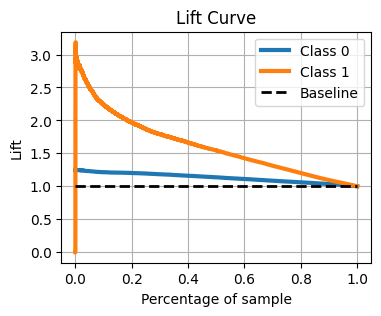

In [34]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('52_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [35]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [36]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('52_REPORT_importance_gain.csv'), index=True)

In [37]:
feat_impgain.head()

,importance
urban_flag,1055.622803
LowDoc,188.369049
DisbursementGross,117.889717
emb_012,35.970318
new_business,35.950275


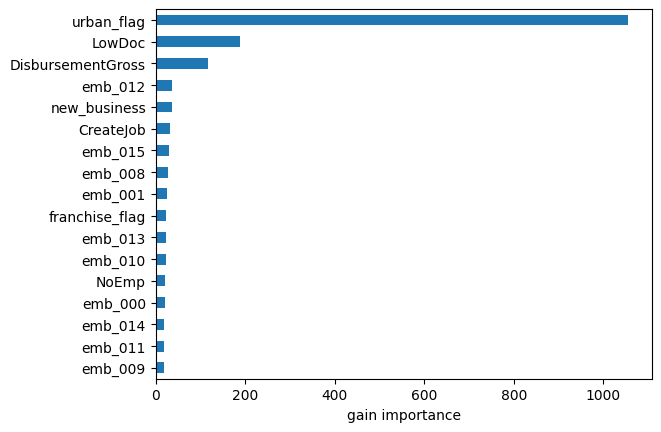

In [38]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('52_PLOT_importance_gain.png'))

##### Permutation Importance

In [39]:
perm_importance = permutation_importance(xgb_model, 
                                         train_df[predictor_features],  train_df['target'],
                                         n_repeats=30, scoring = 'average_precision')

In [40]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [41]:
perm_importance_df.head(5)

,features,importance,abs_importance
3,DisbursementGross,0.080075,0.080075
5,urban_flag,0.042426,0.042426
1,CreateJob,0.026327,0.026327
22,emb_015,0.022420,0.022420
19,emb_012,0.014704,0.014704


In [42]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('52_DATA_importance_perturb.csv'),
            index=False)

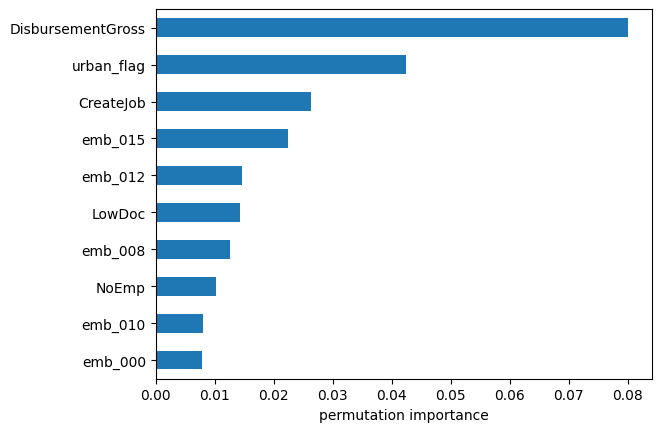

In [43]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('52_PLOT_importance_perturb.png'))

## PDP Plot - Embeddings

In [44]:
def get_pdp(feature):
    results = partial_dependence(xgb_model, train_df[predictor_features], [feature])
    return pd.DataFrame({'grid_values':results["grid_values"][0],
                       'pdp':results["average"][0]})

In [45]:
emb_feat = [c for c in embed_df.columns if c.startswith('emb')]
pdp_res = pd.concat([get_pdp(c) for c in emb_feat], axis=0, keys=emb_feat) 

In [46]:
pdp_res = pdp_res.reset_index(level=0) \
    .rename(columns={'level_0':'feature'})
pdp_res.head()

,feature,grid_values,pdp
0,emb_000,0.219365,0.219052
1,emb_000,0.220030,0.219052
2,emb_000,0.220695,0.219052
3,emb_000,0.221360,0.219052
4,emb_000,0.222026,0.219052


In [47]:
nrow = int(np.ceil(len(emb_feat) / 4))
ncol = 4 if len(emb_feat) % 4 == 0 else 5

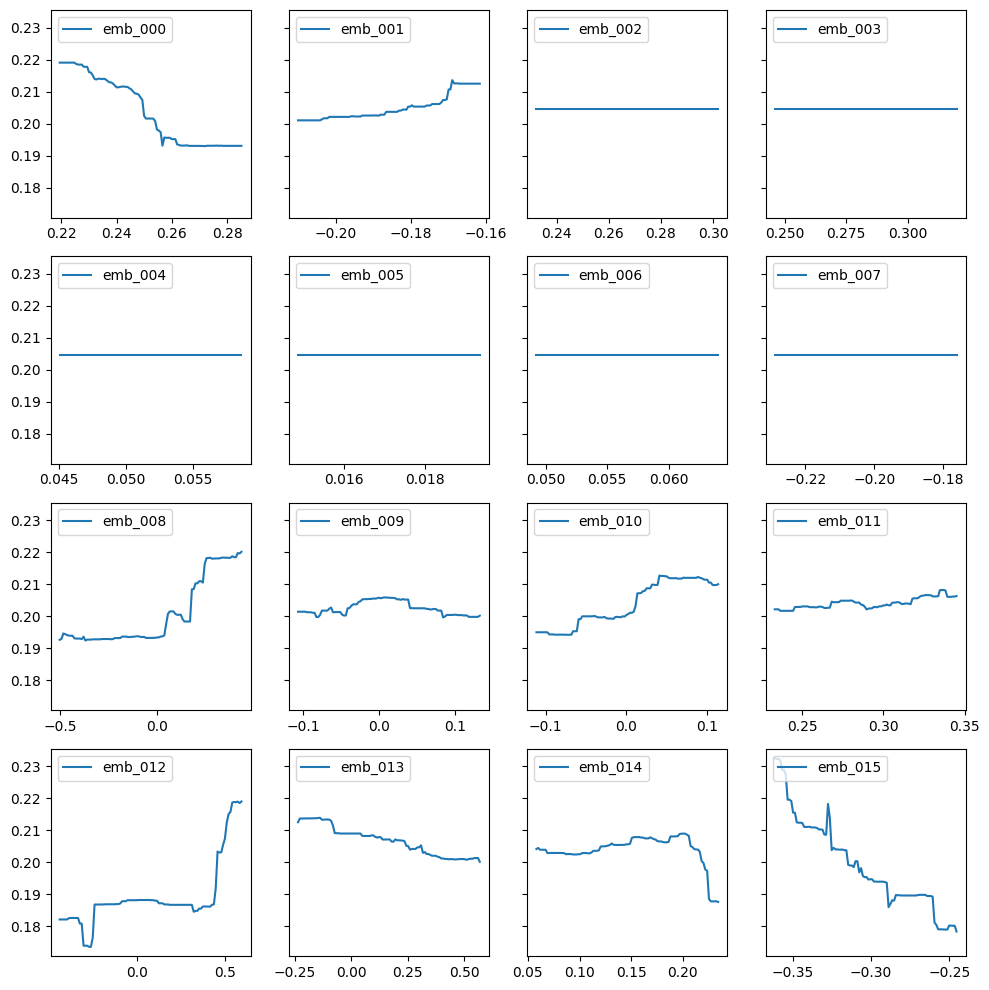

In [48]:
fig, ax = plt.subplots(nrow, ncol, figsize = (10, 10), sharex = False, sharey=True)
for i in range(len(emb_feat)):
    this_row = int(np.floor(i / 4))
    this_col = int(i % 4)
    this_pdp = pdp_res[pdp_res['feature'] == emb_feat[i]]
    #print(f'i:{i}, row:{this_row}, col:{this_col}, feat:{emb_feat[i]}')
    this_pdp.plot(x='grid_values', y='pdp', label=emb_feat[i], ax=ax[this_row, this_col])
    #ax[this_row, this_col].set_title(emb_feat[i])
    ax[this_row, this_col].legend(loc='upper left')
    ax[this_row, this_col].set_xlabel(None)
plt.tight_layout()
plt.show()
fig.savefig(Path(setup.temp_path).joinpath('52_PLOT_pdp_naics_embeddings.png'),
               bbox_inches='tight')